# Main Script

## Inititial Parameters

In [144]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from model import AdaptationModel
import os
import pandas as pd

plotting = True
save_parameters = True

# * ______________________________________________FILE PATHS________________________________________________

# Set file paths for saving results
run_name = "1_BaseCase_Single"  # Replace with the desired run name
sub_folder = "export"
output_folder = f"./{sub_folder}/{run_name}/"
plots_folder = f"{output_folder}/{run_name}_plots"
results_file = f"{output_folder}/{run_name}_results.csv"

# Create the folders if they don't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(plots_folder, exist_ok=True)

# * _________________________________________MODEL and FLOOD________________________________________________

# * Model parameters
seed=1234 # Can be set to None for random seed
number_of_households=100 # Number of households in the model
time_steps=80 # each time step represents a quarter (3 months)
network="watts_strogatz" # Can currently be "erdos_renyi", "barabasi_albert", "watts_strogatz", or "no_network"

# * Flood parameters
flood_map_choice="harvey" # flood_map_choice can be "harvey", "100yr", or "500yr"
time_since_last_flood = 10 # Time since last flood used to update flood probability perception
flood_probability = 0.02 # Probability of flooding in a given time step --> Now 1 in 50 years

# * ________________________________________INCOME and SAVINGS______________________________________________

# * Income parameters
income_distribution = "uniform" # Can be "uniform" or "normal"
income_min = 4000 # Minimum quarterly income
income_max = 80000 # Maximum quarterly income
low_income_threshold = 25000 # maximum quarterly income for bottom 50% of population
medium_income_threshold = 60000 # maximum quarterly income for top 40% of population (excluding top 10%)

# * Savings parameters
savings_share_low_income=0.001 # Share of income saved for low income households
savings_share_medium_income=0.04 # Share of income saved for middle income households
savings_share_high_income=0.2 # Share of income saved for high income households
    # U.S. personal savings rate (personal savings as a percentage of disposable personal income) in April 2023 was 4.1%.
    # SOURCE: https://www.forbes.com/advisor/banking/savings/american-savings-statistics/
    # Saving rate for bottom 50% of population is e.g. 0.1%.
    # Saving rate for top 10% of population is e.g. 20%.
    # Saving rate for rest of population is e.g. 5%.

# * _______________________________________________PMT_____________________________________________________

# * Threat Appraisal_
# + Initial flood probability perception
steepness=0.1 # steepness only for initial calculation
midpoint=50 # midpoint only for initial calculation
flood_probability_percept = 1 / (1 + math.exp(steepness * (time_since_last_flood - midpoint)))
    #  based on time since last flood
    # If time since last flood is 0, flood probability perception is 1

# + Perceived flood damage
# Based on estimated flood depth at agent's location

# + Weights of parameters in threat appraisal
flood_probability_percept_weight = 0.5
flood_damage_percept_weight = 0.5

# * Coping Appraisal
# + Weights of parameters within self efficacy
savings_weight = 0.5  # Weight for the influence of savings on coping appraisal
income_weight = 0.2  # Weight for the influence of income on coping appraisal
social_network_weight = 0.3  # Weight for the influence of social network on coping appraisal

# + Weights of parameters in coping appraisal
self_efficacy_weight = 0.7
coping_efficacy_weight = 0.3

# + Thresholds for Adaptation
threat_threshold = 0.6 # Threshold for threat appraisal
coping_threshold = 0.3 # Threshold for coping appraisal

# * _________________________________________MEASURE and POLICY_____________________________________________

# * Mitigation measure parameters
mitigation_effectiveness = 2.4 # Effectiveness of mitigation measure in meters of elevation
    # eight-foot-elevated homes (~2.4m) now required in parts of Harris County
cost_of_measure=150000 # Cost of mitigation measure
    # --> Check out https://www.bloomberg.com/news/articles/2017-12-08/the-high-cost-of-flood-proofing-homes
    # Different recommended / mandatory elevation heights by government
    # FEMA may provide funding to elevate, but only up to $30,000
    # For houses that are slab-on-grade right now, and want to raise it by using fill,
    # Fill method: $13,000 to $14,000 to do that just one foot
    # Piling method: $180,000 to $200,000 for typical 2,500-square-foot house
    # Necessary elevation of a house

# * Policy parameters
policy = False # "no_policy" # Can be "no_policy" or "subsidy"

low_risk_subsidy_height = 0
medium_risk_subsidy_height = 75000
high_risk_subsidy_height = 150000

low_income_subsidy_factor = 1
medium_income_subsidy_factor = 0.5
high_income_subsidy_factor = 0

# * Individual Risk parameters
low_risk_threshold =    0.000000000004845 # maximum acceptable risk --> low risk
medium_risk_threshold = 0.0000000001 # threshold after which risk is considered high
    # For reference: the percentage of households that are likely to be severyly affected by flooding in Huston is 64%
    # SOURCE: https://riskfactor.com/city/houston-texas/4835000_fsid/flood


### Save Model Parameters to CSV

In [145]:
# Define the model parameters
model_parameters = {
    'seed': seed,
    'number_of_households': number_of_households,
    'network': network,
    'flood_map_choice': flood_map_choice,
    'time_since_last_flood': time_since_last_flood,
    'flood_probability': flood_probability,
    'income_distribution': income_distribution,
    'income_min': income_min,
    'income_max': income_max,
    'low_income_threshold': low_income_threshold,
    'medium_income_threshold': medium_income_threshold,
    'savings_share_low_income': savings_share_low_income,
    'savings_share_medium_income': savings_share_medium_income,
    'savings_share_high_income': savings_share_high_income,
    'flood_probability_percept_weight': flood_probability_percept_weight,
    'flood_damage_percept_weight': flood_damage_percept_weight,
    'savings_weight': savings_weight,
    'income_weight': income_weight,
    'social_network_weight': social_network_weight,
    'self_efficacy_weight': self_efficacy_weight,
    'coping_efficacy_weight': coping_efficacy_weight,
    'threat_threshold': threat_threshold,
    'coping_threshold': coping_threshold,
    'mitigation_effectiveness': mitigation_effectiveness,
    'cost_of_measure': cost_of_measure,
    'policy': policy,
    'low_risk_subsidy_height': low_risk_subsidy_height,
    'medium_risk_subsidy_height': medium_risk_subsidy_height,
    'high_risk_subsidy_height': high_risk_subsidy_height,
    'low_income_subsidy_factor': low_income_subsidy_factor,
    'medium_income_subsidy_factor': medium_income_subsidy_factor,
    'high_income_subsidy_factor': high_income_subsidy_factor,
    'low_risk_threshold': low_risk_threshold,
    'medium_risk_threshold': medium_risk_threshold,
}

if save_parameters:
    # Create a DataFrame from the model parameters
    df_model_parameters = pd.DataFrame([model_parameters])

    # Save the DataFrame to an Excel file
    file_path = f"{output_folder}/{run_name}_parameters.csv"
    df_model_parameters.to_csv(file_path, index=False)

## Run Model

In [146]:
# Initialize the Adaptation Model
model = AdaptationModel(
    seed=seed,
    number_of_households=number_of_households,
    flood_map_choice=flood_map_choice,
    network=network,
    flood_probability=flood_probability,
    time_since_last_flood=time_since_last_flood,

    income_min=income_min,
    income_max=income_max,
    income_distribution=income_distribution,
    low_income_threshold=low_income_threshold,
    medium_income_threshold=medium_income_threshold,
    savings_share_low_income=savings_share_low_income,
    savings_share_medium_income=savings_share_medium_income,
    savings_share_high_income=savings_share_high_income,

    cost_of_measure=cost_of_measure,
    mitigation_effectiveness=mitigation_effectiveness,

    flood_probability_percept=flood_probability_percept,
    flood_probability_percept_weight=flood_probability_percept_weight,
    flood_damage_percept_weight=flood_damage_percept_weight,

    coping_efficacy_weight=coping_efficacy_weight,
    self_efficacy_weight=self_efficacy_weight,
    savings_weight=savings_weight,
    social_network_weight=social_network_weight,

    threat_threshold=threat_threshold,
    coping_threshold=coping_threshold,

    policy=policy,
    low_risk_subsidy_height=low_risk_subsidy_height,
    medium_risk_subsidy_height=medium_risk_subsidy_height,
    high_risk_subsidy_height=high_risk_subsidy_height,
    low_income_subsidy_factor=low_income_subsidy_factor,
    medium_income_subsidy_factor=medium_income_subsidy_factor,
    high_income_subsidy_factor=high_income_subsidy_factor,

    low_risk_threshold=low_risk_threshold,
    medium_risk_threshold=medium_risk_threshold,
    )

# Run the model for X steps
for step in range(time_steps):
    model.step()


## Collect Agent Data

In [147]:
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data

FloodDepthEstimated  FloodDamageEstimated  FloodDepthActual  \
Step AgentID                                                                
0    0                   0.617268              0.564064          0.000000   
     1                   0.595366              0.557756          0.000000   
     2                   0.578775              0.552822          0.000000   
     3                   0.430339              0.501080          0.000000   
     4                   0.450134              0.508933          0.000000   
...                           ...                   ...               ...   
79   95                  2.481976              0.807021          2.784939   
     96                  0.605303              0.560646          0.655731   
     97                  0.469143              0.516154          0.475640   
     98                  1.421329              0.709688          1.277628   
     99                  0.000000              0.000000          0.000000   

              FloodDamageActual  IsAdapted  \
Step AgentID                                 
0    0                 0.000000      False   
     1                 0.000000      False   
     2                 0.000000      False   
     3                 0.000000      False   
     4                 0.000000      False   
...                         ...        ...   
79   95                0.827130      False   
     96                0.574618       True   
     97                0.518556      False   
     98                0.691078       True   
     99                0.000000      False   

                                                   location  FriendsCount  \
Step AgentID                                                                
0    0         POINT (269991.4680110318 3329353.5124918753)             3   
     1         POINT (288355.0069365087 3285380.4237504667)             5   
     2          POINT (290576.7089014455 3296433.448628808)             7   
     3          POINT (273339.0150380993 3276453.873151049)             3   
     4         POINT (218398.55944591787 3316156.611152189)             2   
...                                                     ...           ...   
79   95       POINT (242136.30062427936 3339319.0015903125)             3   
     96       POINT (261902.44034972173 3275872.1720715864)             3   
     97       POINT (242000.99615542975 3310836.9743173043)             5   
     98         POINT (271871.1334261162 3288436.719094755)             4   
     99        POINT (228658.6412502466 3341533.8880646164)             4   

              FriendsNetwork  FriendsAdapted  Income  ... CopingAppraisal  \
Step AgentID                                          ...                   
0    0                   NaN           False   77450  ...             NaN   
     1                   NaN           False   10379  ...             NaN   
     2                   NaN           False    6341  ...             NaN   
     3                   NaN           False   51369  ...             NaN   
     4                   NaN           False   17914  ...             NaN   
...                      ...             ...     ...  ...             ...   
79   95                 33.0           False   43396  ...        0.755308   
     96                 33.0           False   64775  ...        0.832656   
     97                 35.0           False   32534  ...        0.670319   
     98                 28.0           False   64892  ...        0.822361   
     99                 33.0           False   73682  ...        0.548243   

              CopingEfficacy  SelfEfficacy  SavingsContribution  \
Step AgentID                                                      
0    0                   NaN           NaN                  NaN   
     1                   NaN           NaN                  NaN   
     2                   NaN           NaN                  NaN   
     3                   NaN           NaN                  NaN   
     4 

### Save agent data to Excel

In [148]:
# Save the DataFrame to an Excel file
file_path = f"{output_folder}/{run_name}_agent_data.csv"
agent_data.to_csv(file_path, index=True)

## Plot Agent Data

### Plot savings data over time 

<Figure size 800x600 with 0 Axes>

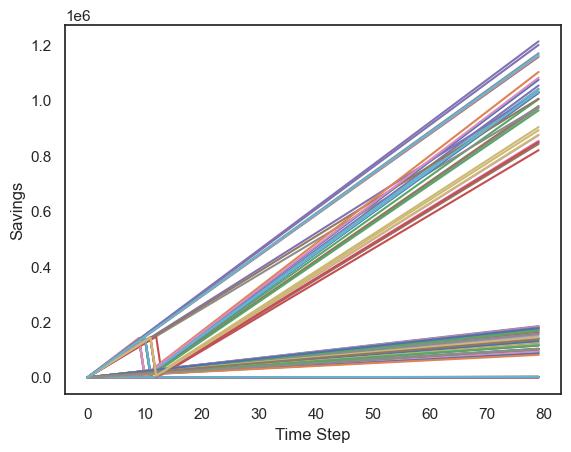

In [165]:
if plotting:
    # Set the size of the plot
    plt.figure(figsize=(8, 6))

    sns.set_theme(style="white")

    # Plot Savings of all agents over time
    agent_data["Savings"].unstack().plot() # .legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    plt.legend().set_visible(False) # Remove legend
    plt.xlabel("Time Step")
    plt.ylabel("Savings")

    plt.savefig(f"{plots_folder}/{run_name}_savings.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot the income distribution of agents

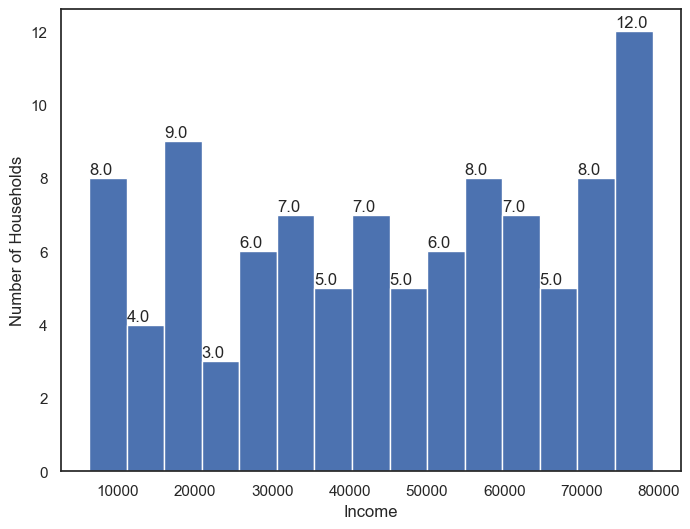

In [163]:
if plotting:
    # Set the size of the plot
    plt.figure(figsize=(8, 6))

    sns.set_theme(style="white")

    # Plot the income distribution at the end of the simulation
    agent_data["Income"].unstack().iloc[-1].plot(kind="hist", bins=15)

    plt.xlabel("Income")
    plt.ylabel("Number of Households")

    # Make sure the y-axis is in integer values
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # add number of households above each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 0.1))

    plt.savefig(f"{plots_folder}/{run_name}_income_distribution.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot Savings distribution at end of simulation

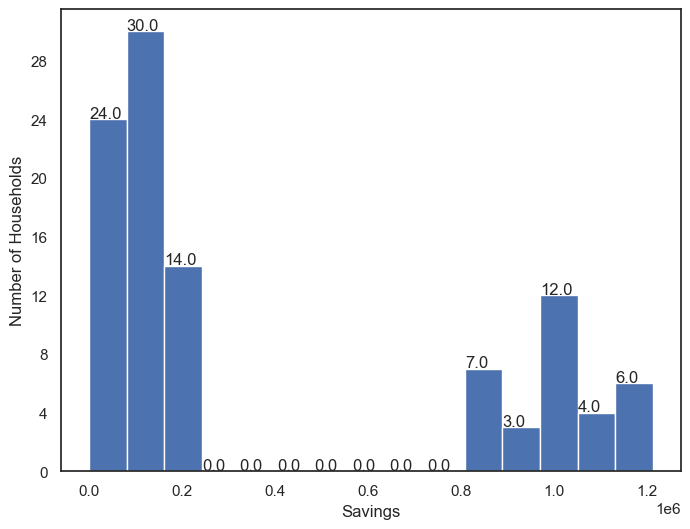

In [164]:
if plotting:
    # Set the size of the plot
    plt.figure(figsize=(8, 6))

    sns.set_theme(style="white")

    # Plot the savings distribution at the end of the simulation
    agent_data["Savings"].unstack().iloc[-1].plot(kind="hist", bins=15)
    plt.xlabel("Savings")
    plt.ylabel("Number of Households")

    # Make sure the y-axis is in integer values
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # add number of households above each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 0.1))

    plt.savefig(f"{plots_folder}/{run_name}_savings_distribution.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot agent distribution to risk groups

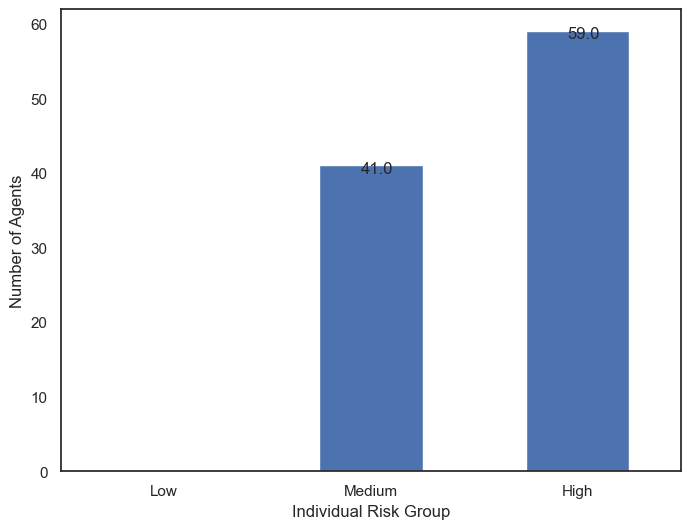

In [166]:
if plotting:

    plt.figure(figsize=(8, 6))

    sns.set_theme(style="white")

    # Plot the number of agents per IndividualRisk group at the end of the simulation
    risk_counts = agent_data["IndividualRisk"].unstack().iloc[-1].value_counts().sort_index()
    total_agents = risk_counts.sum()
    risk_percentages = (risk_counts / total_agents) * 100

    ax = risk_counts.reindex(['low', 'medium', 'high']).plot(kind="bar")
    ax.set_xticklabels(['Low', 'Medium', 'High'], rotation=0)

    ax.set_xlabel("Individual Risk Group")
    ax.set_ylabel("Number of Agents")

    # add number of households above each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + 0.2, p.get_height() - 1))

    plt.savefig(f"{plots_folder}/{run_name}_individual_risk.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot PMT Parameters

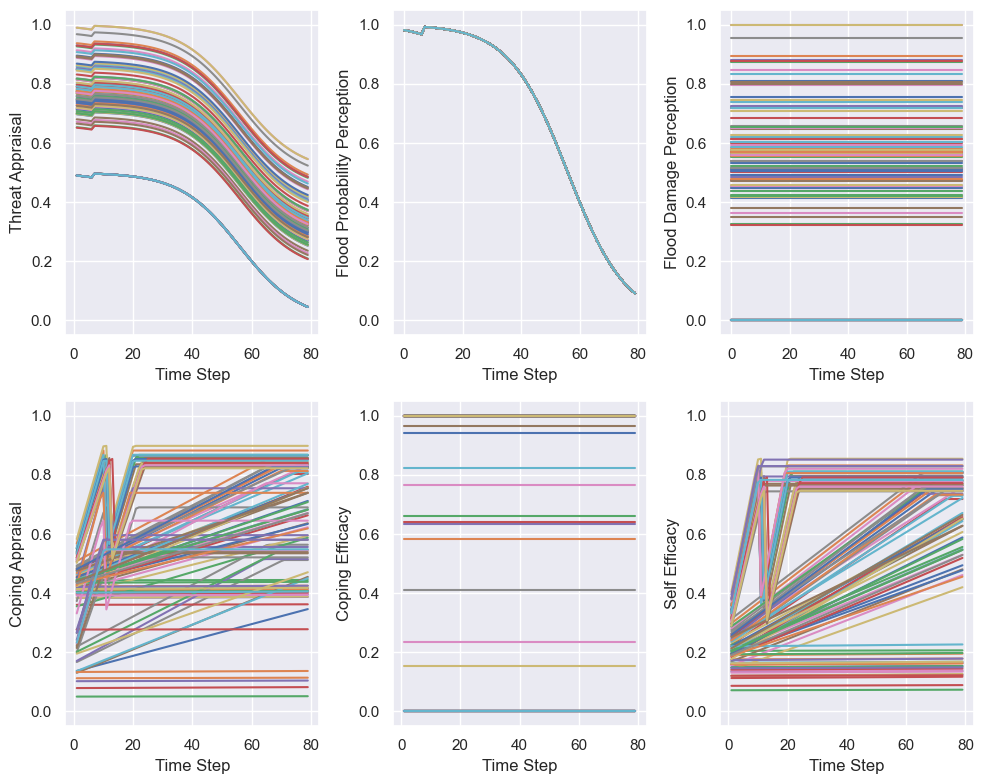

In [169]:
if plotting:
    # plot all the PMT related parameters over time for all agents in one plot
    fig, axes = plt.subplots(2, 3, figsize=(10, 8))

    sns.set_theme(style="white")

    # Set limits for y-axis to be between 0 and 1
    axes[0, 0].set_ylim([-0.05, 1.05])
    axes[0, 1].set_ylim([-0.05, 1.05])
    axes[0, 2].set_ylim([-0.05, 1.05])
    axes[1, 0].set_ylim([-0.05, 1.05])
    axes[1, 1].set_ylim([-0.05, 1.05])
    axes[1, 2].set_ylim([-0.05, 1.05])

    # Threat Appraisal
    axes[0, 0].plot(agent_data["ThreatAppraisal"].unstack())
    axes[0, 0].set_xlabel("Time Step")
    axes[0, 0].set_ylabel("Threat Appraisal")

    # Flood Probability Perception
    axes[0, 1].plot(agent_data["FloodProbabilityPercept"].unstack())
    axes[0, 1].set_xlabel("Time Step")
    axes[0, 1].set_ylabel("Flood Probability Perception")

    # Flood Damage Perception
    axes[0, 2].plot(agent_data["FloodDamagePercept"].unstack())
    axes[0, 2].set_xlabel("Time Step")
    axes[0, 2].set_ylabel("Flood Damage Perception")

    # Coping Appraisal
    axes[1, 0].plot(agent_data["CopingAppraisal"].unstack())
    axes[1, 0].set_xlabel("Time Step")
    axes[1, 0].set_ylabel("Coping Appraisal")

    # Coping Efficacy
    axes[1, 1].plot(agent_data["CopingEfficacy"].unstack())
    axes[1, 1].set_xlabel("Time Step")
    axes[1, 1].set_ylabel("Coping Efficacy")

    # Self Efficacy
    axes[1, 2].plot(agent_data["SelfEfficacy"].unstack())
    axes[1, 2].set_xlabel("Time Step")
    axes[1, 2].set_ylabel("Self Efficacy")

    plt.tight_layout()

    plt.savefig(f"{plots_folder}/{run_name}_pmt.png", dpi=200)
    plt.show()
    plt.close()

### Plot coping appraisal factors

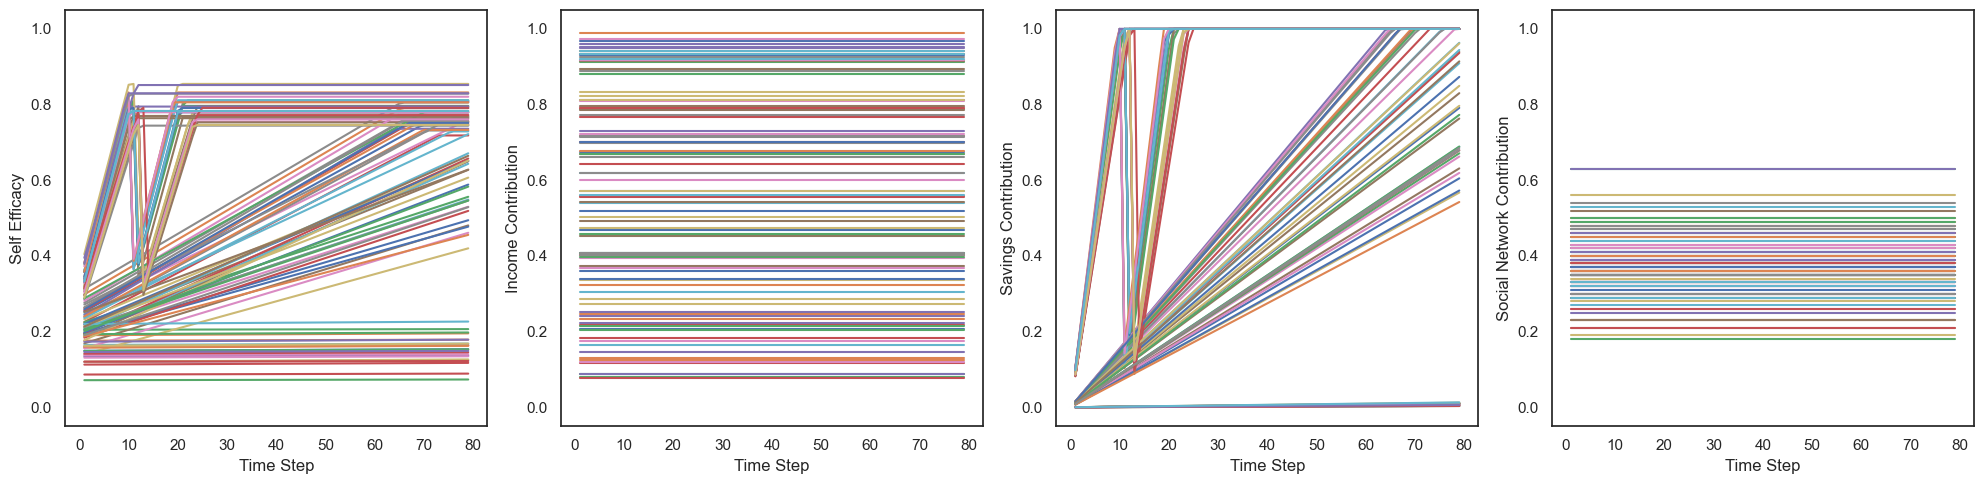

In [171]:
if plotting:
    # plot all the coping appraisal related parameters over time for all agents in one plot: coping appraisal, coping efficacy, self efficacy, income contribution, savings contribution, social network contribution
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    sns.set_theme(style="white")

    # Set limits for y-axis to be between 0 and 1
    axes[0].set_ylim([-0.05, 1.05])
    axes[1].set_ylim([-0.05, 1.05])
    axes[2].set_ylim([-0.05, 1.05])
    axes[3].set_ylim([-0.05, 1.05])

    # Self Efficacy
    axes[0].plot(agent_data["SelfEfficacy"].unstack())
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Self Efficacy")

    # Income Contribution
    axes[1].plot(agent_data["IncomeContribution"].unstack())
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Income Contribution")

    # Savings Contribution
    axes[2].plot(agent_data["SavingsContribution"].unstack())
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Savings Contribution")

    # Social Network Contribution
    axes[3].plot(agent_data["SocialNetworkContribution"].unstack())
    axes[3].set_xlabel("Time Step")
    axes[3].set_ylabel("Social Network Contribution")

    plt.tight_layout()

    plt.savefig(f"{plots_folder}/{run_name}_coping_appraisal.png", dpi=200)

    plt.show()
    plt.close()


## Collect Model Data

In [155]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,TotalAdaptedHouseholds,FloodProbabilityPercept,TimeSinceLastFlood,TotalSubsidiesUsed,TotalDamage,TotalDamageLowIncome,TotalDamageMediumIncome,TotalDamageHighIncome
0,0,0.980160,11,0,0.000000,0.000000,0.00000,0.000000
1,0,0.978119,12,0,0.000000,0.000000,0.00000,0.000000
2,0,0.975873,13,0,0.000000,0.000000,0.00000,0.000000
3,0,0.973403,14,0,0.000000,0.000000,0.00000,0.000000
4,0,0.970688,15,0,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...
75,23,0.119203,70,0,44.742942,10.948339,20.91402,12.880583
76,23,0.109097,71,0,44.742942,10.948339,20.91402,12.880583
77,23,0.099750,72,0,44.742942,10.948339,20.91402,12.880583
78,23,0.091123,73,0,44.742942,10.948339,20.91402,12.880583


### Save model data to CSV

In [156]:
# Save the DataFrame to an Excel file
file_path = f"{output_folder}/{run_name}_model_data.csv"
model_data.to_csv(file_path, index=True)

## Plot Model Data

### Plot adaption status over time 

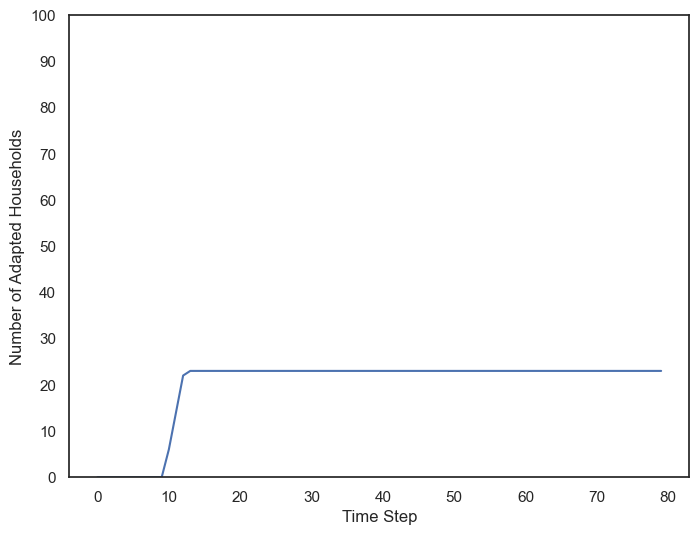

In [172]:
if plotting:
    plt.figure(figsize=(8, 6))

    sns.set_theme(style="white")

    # plot number of total adapted households over time
    model_data["TotalAdaptedHouseholds"].plot()
    plt.xlabel("Time Step")
    plt.ylabel("Number of Adapted Households")

    # Set the y-axis limit to the total number of households in the model
    plt.ylim(0, number_of_households)

    # Make sure the y-axis is in integer values
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.savefig(f"{plots_folder}/{run_name}_adapted_households.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot adaptation status over time vs Total spent subsidies

<Figure size 800x600 with 0 Axes>

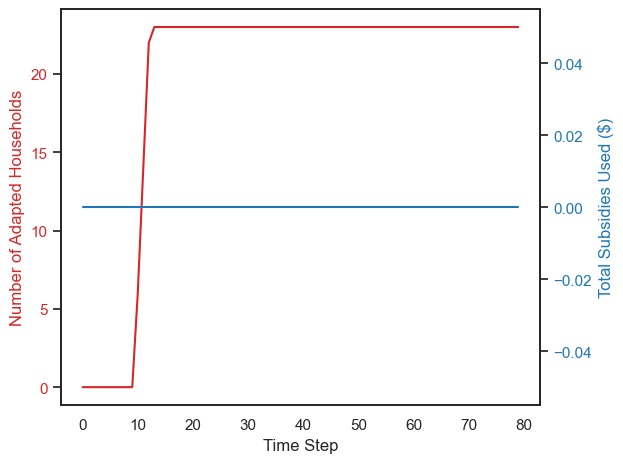

In [173]:
if plotting:
    plt.figure(figsize=(8, 6))
    fig, ax1 = plt.subplots()
    sns.set_theme(style="white")

    # Plot number of adapted households
    color1 = 'tab:red'
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Number of Adapted Households', color=color1)
    ax1.plot(model_data["TotalAdaptedHouseholds"], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    # Plot total subsidies used
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.ticklabel_format(style='plain')
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Subsidies Used ($)', color=color2)
    ax2.plot(model_data["TotalSubsidiesUsed"], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(f"{plots_folder}/{run_name}_adaptation_vs_costs.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot time since last flood and flood probability perception

<Figure size 800x600 with 0 Axes>

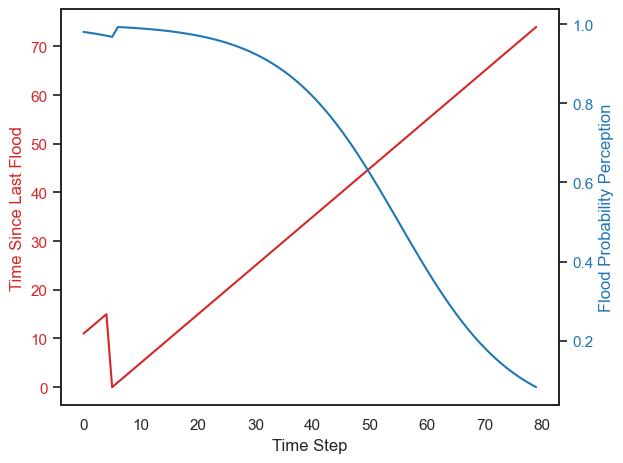

In [174]:
if plotting:
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="white")

    # plot time since last flood and flood probability perception in one plot
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Time Since Last Flood', color=color)
    ax1.plot(model_data["TimeSinceLastFlood"], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Flood Probability Perception', color=color)  # we already handled the x-label with ax1
    ax2.plot(model_data["FloodProbabilityPercept"], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.savefig(f"{plots_folder}/{run_name}_TimeSinceLastFlood_vs_ProbabilityPerception.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()

### Plot total damage over time

<Figure size 800x600 with 0 Axes>

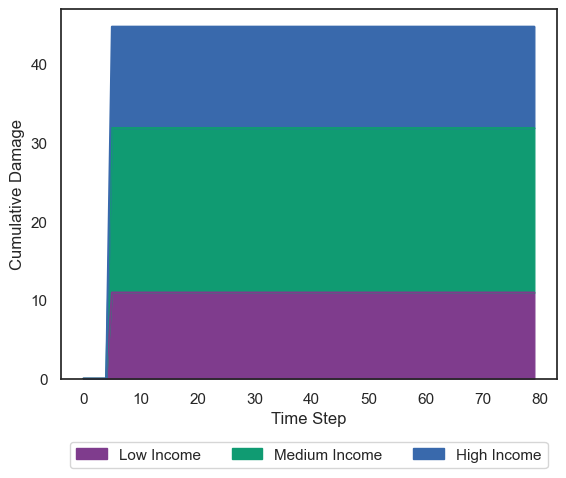

In [176]:
if plotting:

    from matplotlib import patches as mpatches

    # Set the size of the plot
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="white")

    # Plot area chart for TotalDamageLowIncome, TotalDamageMediumIncome, TotalDamageHighIncome
    ax = model_data[["TotalDamageLowIncome", "TotalDamageMediumIncome", "TotalDamageHighIncome"]].plot.area(stacked=True, color=['#7f3c8d', '#109B72', '#3969ac'])

    # Define custom legend patches with specific colors and labels
    legend_patches = [
        mpatches.Patch(color='#7f3c8d', label='Low Income'),
        mpatches.Patch(color='#109B72', label='Medium Income'),
        mpatches.Patch(color='#3969ac', label='High Income')
    ]

    # Add the custom legend
    ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Damage")

    plt.savefig(f"{plots_folder}/{run_name}_cumulative_damage.png", bbox_inches='tight', dpi=150)

    plt.show()
    plt.close()